# Face generator GAN

In [15]:
import zipfile
import random

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML

In [16]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [17]:
# with zipfile.ZipFile('path/to/zip', 'r') as zip_ref:
#     zip_ref.extractall('path/to/extract/folder')

In [18]:
data_path = './data'
img_size = 64
batch_size = 128
latent_size = 100
img_channels = 3
num_channels = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 2e-4
num_epochs = 5
discriminator_iterations = 1
generator_iterations = 1

In [19]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Dataset size = {len(dataset)}')
print(f'Batch shape = {next(iter(dataloader))[0].shape}')

Dataset size = 202599
Batch shape = torch.Size([128, 3, 64, 64])


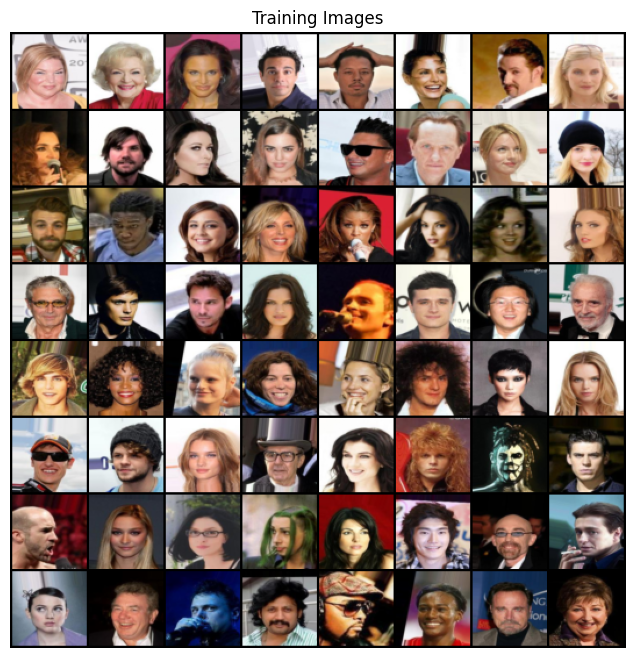

In [20]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, img_channels):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.num_channels = num_channels
        self.img_channels = img_channels

        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 8*num_channels, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_channels * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8*num_channels, 4*num_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_channels * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4*num_channels, 2*num_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_channels * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*num_channels, num_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.ConvTranspose2d(num_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [23]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_channels):
        super(Discriminator, self).__init__()
        self.img_channels = img_channels
        self.num_channels = num_channels

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, 2*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2*num_channels, 4*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(4*num_channels, 8*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8*num_channels, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(-1, 1)

In [24]:
generator = Generator(latent_size, num_channels, img_channels).to(device)
generator.apply(weights_init)
summary(generator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [25]:
discriminator = Discriminator(img_channels, num_channels).to(device)
discriminator.apply(weights_init)
summary(discriminator, (img_channels, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [26]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [27]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        opt_discriminator.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        opt_generator.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/1583]	Loss_D: 1.4100	Loss_G: 3.1671	D(x): 0.4374	D(G(z)): 0.3056 / 0.0571
[0/5][50/1583]	Loss_D: 0.0284	Loss_G: 34.3283	D(x): 0.9823	D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 

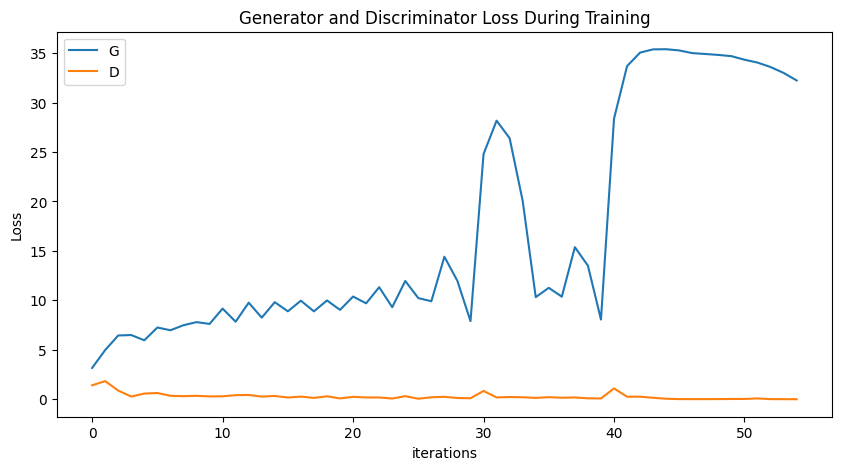

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

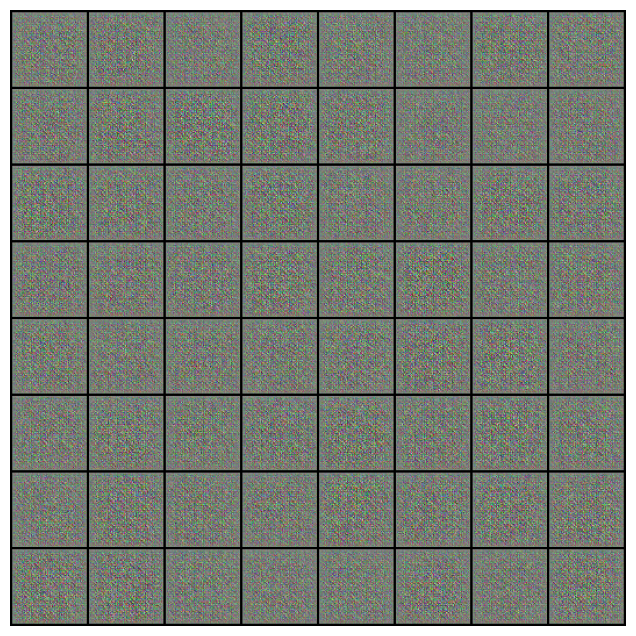

In [29]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

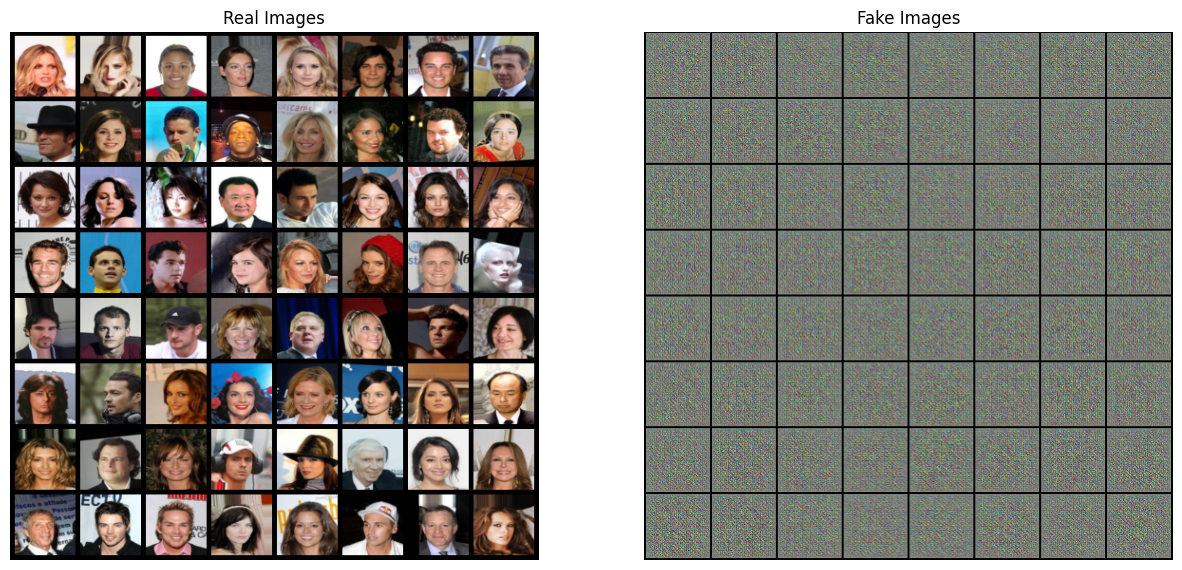

In [30]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()